In [35]:
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/indian-medicinal-leaf-image-dataset/Medicinal Leaf dataset/Tecoma/20190920_143442.jpg
/kaggle/input/indian-medicinal-leaf-image-dataset/Medicinal Leaf dataset/Tecoma/20190920_143720.jpg
/kaggle/input/indian-medicinal-leaf-image-dataset/Medicinal Leaf dataset/Tecoma/20190920_141501.jpg
/kaggle/input/indian-medicinal-leaf-image-dataset/Medicinal Leaf dataset/Tecoma/20190920_143337.jpg
/kaggle/input/indian-medicinal-leaf-image-dataset/Medicinal Leaf dataset/Tecoma/20190920_143438.jpg
/kaggle/input/indian-medicinal-leaf-image-dataset/Medicinal Leaf dataset/Tecoma/20190920_142808.jpg
/kaggle/input/indian-medicinal-leaf-image-dataset/Medicinal Leaf dataset/Tecoma/20190920_144011.jpg
/kaggle/input/indian-medicinal-leaf-image-dataset/Medicinal Leaf dataset/Tecoma/20190920_143756.jpg
/kaggle/input/indian-medicinal-leaf-image-dataset/Medicinal Leaf dataset/Tecoma/20190920_143244.jpg
/kaggle/input/indian-medicinal-leaf-image-dataset/Medicinal Leaf dataset/Tecoma/20190920_142444.jpg


### Importing the necessary libraries, classes and functions

In [37]:
import os
import shutil
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Model,Sequential,save_model,load_model
from tensorflow.config import list_physical_devices
from tensorflow.config.experimental import set_memory_growth

import warnings
warnings.filterwarnings("ignore")

#### Defining the paths for writing and reading files

In [41]:
# Paths
root_dir = r"/kaggle/input/indian-medicinal-leaf-image-dataset/Medicinal Leaf dataset"
out_dir = r"/kaggle/working"

In [42]:
count = 0
f = 0
for folder in os.listdir(root_dir):    
    folder_paths = os.path.join(root_dir,folder)
    for image in folder_paths:
        count += 1
print(count)

6466


* identifing the devices and setting memory growth so the GPU allocates the memory when there is requirement only instead of assigning all the memory in the beginning


In [43]:
device = list_physical_devices("GPU")
print(device)

if device:
    try:
        tf.config.experimental.set_memory_growth(device[0], True)
    except RuntimeError as e:
        print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


* Make directories in the output directory to copy the data so that, it can be manipulated and saved in the required format( Data Collection )

In [44]:
for folder in os.listdir(root_dir):    
    folder_paths = os.path.join(out_dir,"data",str(folder))
    os.makedirs(folder_paths,exist_ok = True)

### Data Validation 

* Checking whether all the images (data) is in the required format. Saving only the correct data into the directories

In [45]:
from PIL import Image

def validate_image(image_path):
    try:
        img = Image.open(image_path)
        img.verify()  # Raises an error for corrupt images
        return True
    except Exception as e:
        print(f"Invalid image for {image_path}: {e}")
        return False
    

In [46]:
data = r"/kaggle/working/data"

for names in os.listdir(data):
    filepaths = os.path.join(root_dir,names)
    for files in os.listdir(filepaths):
            val = validate_image(os.path.join(filepaths,files))
            if val:
                image = Image.open(os.path.join(filepaths,files))
                image.save(os.path.join(data,names,files))

Invalid image for /kaggle/input/indian-medicinal-leaf-image-dataset/Medicinal Leaf dataset/Spinach1/VID_20190917_104022.mp4: cannot identify image file '/kaggle/input/indian-medicinal-leaf-image-dataset/Medicinal Leaf dataset/Spinach1/VID_20190917_104022.mp4'
Invalid image for /kaggle/input/indian-medicinal-leaf-image-dataset/Medicinal Leaf dataset/Spinach1/VID_20190917_103758.mp4: cannot identify image file '/kaggle/input/indian-medicinal-leaf-image-dataset/Medicinal Leaf dataset/Spinach1/VID_20190917_103758.mp4'
Invalid image for /kaggle/input/indian-medicinal-leaf-image-dataset/Medicinal Leaf dataset/Spinach1/VID_20190917_103955.mp4: cannot identify image file '/kaggle/input/indian-medicinal-leaf-image-dataset/Medicinal Leaf dataset/Spinach1/VID_20190917_103955.mp4'
Invalid image for /kaggle/input/indian-medicinal-leaf-image-dataset/Medicinal Leaf dataset/Sapota/VID_20190921_120806.mp4: cannot identify image file '/kaggle/input/indian-medicinal-leaf-image-dataset/Medicinal Leaf data

### Preparing training and validation, testing data 

In [47]:
batch_size = 32
image_width = 224
image_height = 224

In [48]:
import tensorflow as tf

# List all available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # Set memory growth for each GPU
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)  # Memory growth must be set before GPUs are initialized

# Now define the dataset after setting memory growth
dataset = tf.keras.preprocessing.image_dataset_from_directory(
             data,
             labels='inferred',
             label_mode='int',
             color_mode='rgb',
             class_names=None,
             batch_size=batch_size,
             image_size=(image_height, image_width),
             shuffle=True,
             seed=123
)

Found 6900 files belonging to 80 classes.


In [49]:
len(dataset)                              # 216 * 32  

216

In [50]:
classnames = dataset.class_names

In [51]:
print(classnames, sep = ",")

['Aloevera', 'Amla', 'Amruthaballi', 'Arali', 'Astma_weed', 'Badipala', 'Balloon_Vine', 'Bamboo', 'Beans', 'Betel', 'Bhrami', 'Bringaraja', 'Caricature', 'Castor', 'Catharanthus', 'Chakte', 'Chilly', 'Citron lime (herelikai)', 'Coffee', 'Common rue(naagdalli)', 'Coriender', 'Curry', 'Doddpathre', 'Drumstick', 'Ekka', 'Eucalyptus', 'Ganigale', 'Ganike', 'Gasagase', 'Ginger', 'Globe Amarnath', 'Guava', 'Henna', 'Hibiscus', 'Honge', 'Insulin', 'Jackfruit', 'Jasmine', 'Kambajala', 'Kasambruga', 'Kohlrabi', 'Lantana', 'Lemon', 'Lemongrass', 'Malabar_Nut', 'Malabar_Spinach', 'Mango', 'Marigold', 'Mint', 'Neem', 'Nelavembu', 'Nerale', 'Nooni', 'Onion', 'Padri', 'Palak(Spinach)', 'Papaya', 'Parijatha', 'Pea', 'Pepper', 'Pomoegranate', 'Pumpkin', 'Raddish', 'Rose', 'Sampige', 'Sapota', 'Seethaashoka', 'Seethapala', 'Spinach1', 'Tamarind', 'Taro', 'Tecoma', 'Thumbe', 'Tomato', 'Tulsi', 'Turmeric', 'ashoka', 'camphor', 'kamakasturi', 'kepala']


In [52]:
for image_batch,label_batch in dataset.take(1):     # .take(1) => takes 1 batch , 1 can be choice
    print(image_batch.shape, label_batch.shape)

(32, 224, 224, 3) (32,)


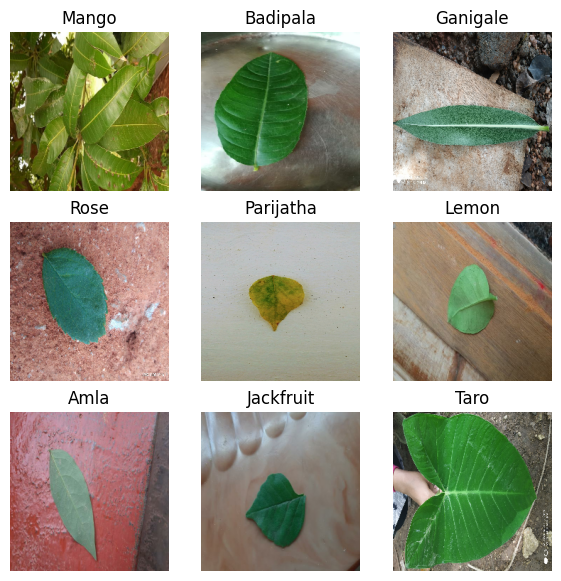

In [53]:
plt.figure(figsize = (7,7))
for images,labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(classnames[labels[i]])
        plt.axis("off")

#### training     ==> 80 %
#### Validation   ==> 10%
#### Testing      ==> 10%

In [54]:
# Train data

train_size = 0.8 
train_data = dataset.take(int(len(dataset)*train_size))
print(len(train_data))

172


In [55]:
test_data = dataset.skip(int(len(dataset)*train_size))

val_size = 0.1

valid_data = test_data.take(int(len(dataset)*val_size))

test_data = test_data.skip(int(len(dataset)*val_size))

print(len(valid_data),len(test_data))

21 23


#### Speed up loading the data into memory

In [56]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().prefetch(buffer_size = AUTOTUNE)

valid_data = valid_data.cache().prefetch(buffer_size = AUTOTUNE)

test_data = test_data.cache().prefetch(buffer_size = AUTOTUNE)

#### data augmentation, resize and rescale 

In [57]:
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(image_height,image_width),
  tf.keras.layers.Rescaling(1./255),
])

data_augmentation = tf.keras.Sequential([
#   tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation(0.2),
])

### Model Building

Pre-trained model(InceptionResnetV2) is being imported as a base model, data augmentation isn't performed well in this case hence removed. Then custom dense layers are added to the pre trained model to use transfer learning. As it involves training the new layers, dropout is being used to avoid overfitting the model. Then output layer is modified to the use case (80 classes).

In [ ]:
from tensorflow.keras.applications import EfficientNetV2B3  # Adjust this as per your needs
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
import tensorflow as tf

# Create EfficientNetV2 model
def create_model(freeze=True):
    PernNet_model = EfficientNetV2B3(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    
    if freeze:
        PernNet_model.trainable = False
    
    # Add custom layers on top of EfficientNetV2
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(224, 224, 3)),
        PernNet_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(80, activation='softmax')  # Adjust for the number of classes
    ])
    
    return model

# Instantiate the model
model = create_model(freeze=False)  # You can freeze or unfreeze layers




Here single learning rate is not used. Instead multiple learning rates are used in different boundaries. i.e 

* 1 - 20 ==> 0.0001
* 21-35  ==> 0.0005
* 35-50  ==> 0.001

This approach is used to converge the model so the performance will inturn increased


In [81]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping

# ModelCheckpoint callback to save model after every epoch
checkpoint = ModelCheckpoint(
    filepath='/kaggle/working/mod_{epoch}.keras',  
    save_best_only=True,  
    monitor='val_accuracy',  
    save_weights_only=False,  
    verbose=1  
)

# EarlyStopping callback to stop training if validation accuracy doesn't improve
early_stopping = EarlyStopping(
    monitor='val_accuracy',  
    min_delta=0.05,  
    patience=50,  
    baseline = 0.5,
    restore_best_weights=True  
)

In [82]:
from tensorflow.keras.optimizers import AdamW
stratergy = tf.distribute.experimental.CentralStorageStrategy()
stratergy = tf.distribute.experimental.CentralStorageStrategy()


with stratergy.scope():
    
    model = create_model(freeze = False)
  
    model.summary()
    optimizer = AdamW(learning_rate=0.001, weight_decay=1e-4)  # Adjust learning rate and weight decay
    model.compile(optimizer=optimizer, 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b3 (Functio  (None, 7, 7, 1536)        12930622  
 nal)                                                            
                                                                 
 global_average_pooling2d_1  (None, 1536)              0         
 2 (GlobalAveragePooling2D)                                      
                                                                 
 dense_32 (Dense)            (None, 256)               393472    
                                                                 
 dropout_20 (Dropout)        (None, 256)               0         
                                                                 
 dense_33 (Dense)            (None, 80)                20560     
                                                                 
Total params: 13344654 (50.91 MB)
Trainable params: 1

* Model is being trained on P100 GPU using CentralStorageStratergy for faster training. 

* Final model is not just leveraged benifits of transfer-learning, but fine tuned for better performance. There's good chance that model will be overfit during fine-tuning. To tacke that, multiple low learning rates were used across boundaries 

In [83]:
# Compile the model with Adam optimizer
optimizer = Adam(learning_rate=1e-4)  # You can adjust learning rate if needed
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])



In [85]:
# Train the model
history = model.fit(train_data,  # Your training dataset
                    epochs=20,   # Number of epochs (adjust as needed)
                    validation_data=valid_data,  # Your validation dataset
                    callbacks=[checkpoint, early_stopping])  # Assuming checkpoint & early stopping defined


Epoch 1/20
172/172 [==============================] - ETA: 0s - loss: 3.9755 - accuracy: 0.1346
Epoch 1: val_accuracy improved from -inf to 0.44345, saving model to /kaggle/working/mod_1.keras
172/172 [==============================] - 111s 250ms/step - loss: 3.9755 - accuracy: 0.1346 - val_loss: 3.0904 - val_accuracy: 0.4435
Epoch 2/20
172/172 [==============================] - ETA: 0s - loss: 2.2504 - accuracy: 0.5356
Epoch 2: val_accuracy improved from 0.44345 to 0.75893, saving model to /kaggle/working/mod_2.keras
172/172 [==============================] - 40s 233ms/step - loss: 2.2504 - accuracy: 0.5356 - val_loss: 1.2321 - val_accuracy: 0.7589
Epoch 3/20
172/172 [==============================] - ETA: 0s - loss: 0.8879 - accuracy: 0.8176
Epoch 3: val_accuracy improved from 0.75893 to 0.92708, saving model to /kaggle/working/mod_3.keras
172/172 [==============================] - 40s 233ms/step - loss: 0.8879 - accuracy: 0.8176 - val_loss: 0.4298 - val_accuracy: 0.9271
Epoch 4/20
1

In [94]:
# Train the model
history = model.fit(train_data,  # Your training dataset
                    epochs=10,   # Number of epochs (adjust as needed)
                    validation_data=valid_data,  # Your validation dataset
                    callbacks=[checkpoint, early_stopping])  # Assuming checkpoint & early stopping defined


Epoch 1/10
172/172 [==============================] - ETA: 0s - loss: 0.0125 - accuracy: 0.9978
Epoch 1: val_accuracy did not improve from 0.97619
172/172 [==============================] - 37s 217ms/step - loss: 0.0125 - accuracy: 0.9978 - val_loss: 0.0984 - val_accuracy: 0.9717
Epoch 2/10
172/172 [==============================] - ETA: 0s - loss: 0.0155 - accuracy: 0.9976
Epoch 2: val_accuracy did not improve from 0.97619
172/172 [==============================] - 37s 214ms/step - loss: 0.0155 - accuracy: 0.9976 - val_loss: 0.1276 - val_accuracy: 0.9628
Epoch 3/10
172/172 [==============================] - ETA: 0s - loss: 0.0155 - accuracy: 0.9958
Epoch 3: val_accuracy did not improve from 0.97619
172/172 [==============================] - 37s 214ms/step - loss: 0.0155 - accuracy: 0.9958 - val_loss: 0.1561 - val_accuracy: 0.9583
Epoch 4/10
172/172 [==============================] - ETA: 0s - loss: 0.0316 - accuracy: 0.9920
Epoch 4: val_accuracy did not improve from 0.97619
172/172 [=

In [95]:
model.save("/kaggle/working/model_final.keras")

#### Validation Accuracy reached 93.45%

In [96]:
model.evaluate(test_data)

23/23 [==============================] - 2s 58ms/step - loss: 0.1322 - accuracy: 0.9655


[0.13223761320114136, 0.9654695987701416]

#### Test accuracy reached ~91 % which would be far better than the custom CNN and pre-trained models (Transfer learning) (validation accuracy for pre trained ~= 62 %)

In [97]:
train_accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

In [98]:
epochs = 30

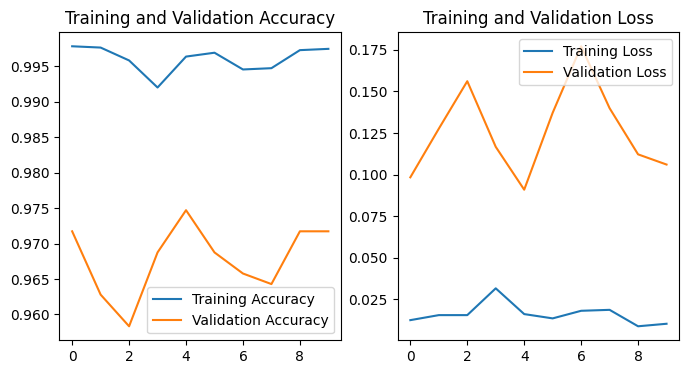

In [99]:
# Get the number of epochs from the history object
epochs = len(train_accuracy)

plt.figure(figsize=(8,4))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_accuracy, label='Training Accuracy')
plt.plot(range(epochs), val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


#### Inference/Prediction

In [100]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)       # Creating a batch with the image
    
    predictions = model.predict(img_array,verbose = 0)
    predicted_class = classnames[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])),2)
    return predicted_class, confidence

In [101]:
print(len(train_data),len(valid_data),len(test_data))
for images,labels in test_data.take(1):
    print(images.numpy().shape)

172 21 23
(32, 224, 224, 3)


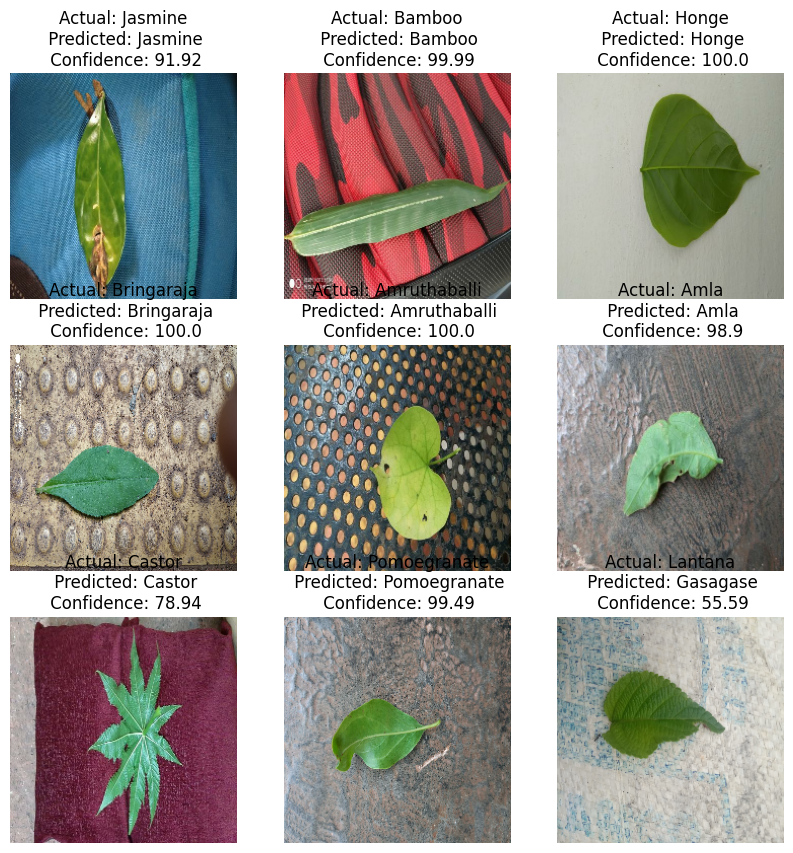

In [102]:
plt.figure(figsize = (10,10))
for images,labels in test_data.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.axis("off")
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted, confidence = predict(model, images.numpy())
        plt.title(f"Actual: {classnames[labels[i]]}\n Predicted: {predicted}\n Confidence: {confidence}")
#     predicted_class = classnames[np.argmax(predicted[0])]
#     print(predicted_class, classnames[labels[i]])